In [81]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import geopandas as gpd
from __future__ import print_function, division
import matplotlib.pyplot as plt
import pylab as pl
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import os
import urllib
import requests
import json
import zipfile
import shapely
import scipy.stats as stats
import io
from io import StringIO
import random
from matplotlib import pyplot
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
from math import sin, cos, sqrt, atan2, radians


# 1) Data Collection

## 1.1) NYC Borough Outline

In [82]:
#Collect Borough shapefile
urllib.request.urlretrieve('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile',
                           'outline.gz')

('outline.gz', <http.client.HTTPMessage at 0x7fb76b45ccf8>)

In [83]:
#Move it to PUIDATA
!mv outline.gz $PUIDATA

In [84]:
#Unzip it
zip_ref = zipfile.ZipFile(os.getenv("PUIDATA") + '/outline.gz', 'r')
zip_ref.extractall(os.getenv("PUIDATA"))
zip_ref.close()

In [85]:
#Read it into the ipynb
outline = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + '/geo_export_5b57fd49-f3a9-46a3-b7b7-64d029f3ca08.shp')

Text(0.5,15,'Longitude')

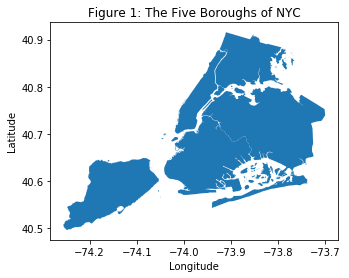

In [86]:
#Plot borough shapefile
ax = outline.plot()
ax.set_title('Figure 1: The Five Boroughs of NYC')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

Figure 1 displays the five boroughs of NYC. The purpose of this map is to serve as background when shapes from othershapefiles are removed across NYC based on certain logicals. When shapes are removed, the backdrop of of this map will keep the integrity of the NYC boarders.

## 1.2) Get & Clean the Poll Site Data

In [87]:
#Download poll site data
!curl https://data.cityofnewyork.us/api/views/utqd-4534/rows.csv?accessType=DOWNLOAD > poll_sites.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  254k    0  254k    0     0   396k      0 --:--:-- --:--:-- --:--:--  397k


In [88]:
#Move the poll site data to PUIDATA
!mv poll_sites.csv $PUIDATA

In [89]:
#Read in the poll site data
poll_sites = pd.read_csv(os.getenv("PUIDATA") + '/poll_sites.csv')
poll_sites.head()

,SITE_NAME,SITE_NUMBER,VOTER_ENTRANCE,HANDICAP_ENTRANCE,STREET_NUMBER,STREET_NAME,STREET_SUFFIX,SITE_STATUS,CITY,POSTCODE,Community Board,Latitude,BOROUGH,Longitude,Council District,Census Tract,BIN,BBL,NTA,Location
0,Windsor Tower,10205,5 Tudor City Place,East 40th Street,5,Tudor City Place,NaN,A,New York,10017,6.0,40.748068,MANHATTAN,-73.971083,4.0,88.0,1038647.0,1.013330e+09,Turtle Bay-East Midtown,"(40.748068, -73.971083)"
1,Dream Charter School,11642,1991 2 Avenue,1991 2 Avenue,1991,2 Avenue,NaN,A,New York,10029,11.0,NaN,MANHATTAN,NaN,8.0,164.0,1000000.0,1.016520e+09,East Harlem South,NaN
2,Church of the Holy Apostles,11650,296 9 Avenue,296 9 Avenue,296,9 Avenue,NaN,A,New York,10001,4.0,NaN,MANHATTAN,NaN,3.0,97.0,1013463.0,1.007510e+09,Hudson Yards-Chelsea-Flatiron-Union Square,NaN
3,Lower East Side Girls Club,11657,402 East 8th Street,402 East 8th Street,402,East 8 Street,NaN,A,New York,10009,3.0,NaN,MANHATTAN,NaN,2.0,2602.0,1089381.0,1.003778e+09,Lower East Side,NaN
4,Campos Community Center,10142,611 East 13 Street,611 East 13 Street,611,East 13 Street,NaN,A,New York,10009,3.0,40.728725,MANHATTAN,-73.978294,2.0,28.0,1077502.0,1.003960e+09,Lower East Side,"(40.728725, -73.978294)"


In [90]:
#Create a geometric point of the coordinates for mapping purposes
poll_sites['Coordinates'] = list(zip(poll_sites.Longitude, poll_sites.Latitude))
poll_sites['geometry'] = poll_sites[['Coordinates']].applymap(lambda x:shapely.geometry.Point(x))
poll_sites.head()

,SITE_NAME,SITE_NUMBER,VOTER_ENTRANCE,HANDICAP_ENTRANCE,STREET_NUMBER,STREET_NAME,STREET_SUFFIX,SITE_STATUS,CITY,POSTCODE,...,BOROUGH,Longitude,Council District,Census Tract,BIN,BBL,NTA,Location,Coordinates,geometry
0,Windsor Tower,10205,5 Tudor City Place,East 40th Street,5,Tudor City Place,NaN,A,New York,10017,...,MANHATTAN,-73.971083,4.0,88.0,1038647.0,1.013330e+09,Turtle Bay-East Midtown,"(40.748068, -73.971083)","(-73.971083, 40.748068)",POINT (-73.97108299999999 40.748068)
1,Dream Charter School,11642,1991 2 Avenue,1991 2 Avenue,1991,2 Avenue,NaN,A,New York,10029,...,MANHATTAN,NaN,8.0,164.0,1000000.0,1.016520e+09,East Harlem South,NaN,"(nan, nan)",POINT (nan nan)
2,Church of the Holy Apostles,11650,296 9 Avenue,296 9 Avenue,296,9 Avenue,NaN,A,New York,10001,...,MANHATTAN,NaN,3.0,97.0,1013463.0,1.007510e+09,Hudson Yards-Chelsea-Flatiron-Union Square,NaN,"(nan, nan)",POINT (nan nan)
3,Lower East Side Girls Club,11657,402 East 8th Street,402 East 8th Street,402,East 8 Street,NaN,A,New York,10009,...,MANHATTAN,NaN,2.0,2602.0,1089381.0,1.003778e+09,Lower East Side,NaN,"(nan, nan)",POINT (nan nan)
4,Campos Community Center,10142,611 East 13 Street,611 East 13 Street,611,East 13 Street,NaN,A,New York,10009,...,MANHATTAN,-73.978294,2.0,28.0,1077502.0,1.003960e+09,Lower East Side,"(40.728725, -73.978294)","(-73.978294, 40.728725)",POINT (-73.97829399999999 40.728725)


Text(47.2175,0.5,'Latitude')

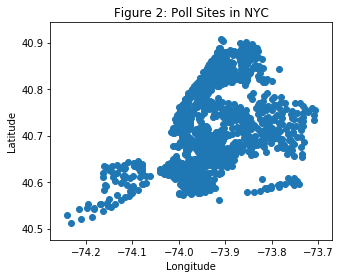

In [91]:
#Plot the location of all poll sites
poll_sites = gpd.GeoDataFrame(poll_sites)
ax = poll_sites.plot()
ax.set_title('Figure 2: Poll Sites in NYC')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

Figure 2 shows the polling sites across NYC. There are 1231 of them. One thing that is interesting to note is the shape that the poll sites take, almost looking like Figure 1 above.

## 1.3) Get the Election District Shapefile

In [101]:
#Retreive election districtz zipfile
urllib.request.urlretrieve('https://data.cityofnewyork.us/api/geospatial/h2n3-98hq?method=export&format=Shapefile',
                           'ed.gz')

('ed.gz', <http.client.HTTPMessage at 0x7fb74af032e8>)

In [102]:
#Move it to PUIDATA
!mv ed.gz $PUIDATA

In [103]:
#Unzip it 
zip_ref = zipfile.ZipFile(os.getenv("PUIDATA") + '/ed.gz', 'r')
zip_ref.extractall(os.getenv("PUIDATA"))
zip_ref.close()

In [104]:
#Read in shapefile as a geodataframe
ed = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + '/geo_export_dc88aad6-5593-4c8e-a24f-1226da1e4ed2.shp')

In [105]:
#Display data
ed.head()

,elect_dist,shape_area,shape_leng,geometry
0,23002.0,5.646614e+06,13511.950233,POLYGON ((-73.91313180128004 40.56463824394601...
1,23004.0,1.516480e+07,27487.651010,"POLYGON ((-73.86495467575234 40.5666314776016,..."
2,23005.0,6.156202e+06,16269.643434,"POLYGON ((-73.85901463392794 40.5779871113073,..."
3,23006.0,3.188046e+06,8261.763749,POLYGON ((-73.85324184655673 40.57138361205507...
4,23007.0,3.454289e+06,10778.549525,POLYGON ((-73.84850444718799 40.57214844758093...


In [106]:
#Turn election district into an integer
ed['elect_dist'] = ed['elect_dist'].astype(str)

Text(44.2588,0.5,'Latitude')

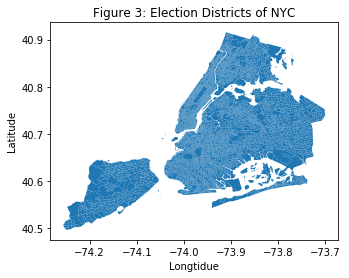

In [107]:
#Plot the election district shapefile
ax  = ed.plot()
ax.set_title('Figure 3: Election Districts of NYC')
ax.set_xlabel('Longtidue')
ax.set_ylabel('Latitude')

Figure 3 displays all the election districts across NYC. This mapped geodataframe will be used to visualize different features across NYC districts, such as voter turnout and distance to polls. 

## 1.4) Collect NYCHA Housing Data

In [108]:
#Retreive NYCHA housing zipfile
urllib.request.urlretrieve('https://data.cityofnewyork.us/api/geospatial/i9rv-hdr5?method=export&format=Shapefile',
                           'nycha.gz')

('nycha.gz', <http.client.HTTPMessage at 0x7fb76b17edd8>)

In [109]:
#Move file to PUIDATA
!mv nycha.gz $PUIDATA

In [110]:
#Unzip it 
zip_ref = zipfile.ZipFile(os.getenv("PUIDATA") + '/nycha.gz', 'r')
zip_ref.extractall(os.getenv("PUIDATA"))
zip_ref.close()

In [111]:
#Read in the data as a geodataframe
nycha = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + '/geo_export_8132a2a2-5933-4dc3-a1bb-c7aaa5fc9e75.shp')
nycha.head()

,borough,developmen,tds_num,geometry
0,VARIOUS,FHA REPOSSESSED HOUSES (GROUP III),213,(POLYGON ((-73.93559146071932 40.6594891659253...
1,VARIOUS,FHA REPOSSESSED HOUSES (GROUP IV),226,(POLYGON ((-73.92913654009605 40.6620874071209...
2,VARIOUS,FHA REPOSSESSED HOUSES (GROUP VII),274,(POLYGON ((-73.76955112561133 40.6615154004818...
3,VARIOUS,FHA REPOSSESSED HOUSES (GROUP VIII),275,(POLYGON ((-73.7935323517346 40.67461675600666...
4,VARIOUS,FHA REPOSSESSED HOUSES (GROUP V),260,(POLYGON ((-73.92285468610142 40.6560250263966...


Text(31.559,0.5,'Feet')

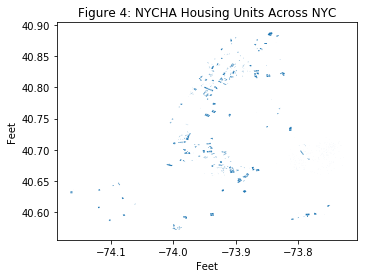

In [112]:
#Plot the NYCHA housing data
nycha_map = gpd.GeoDataFrame(nycha)
ax = nycha.plot()
ax.set_title('Figure 4: NYCHA Housing Units Across NYC')
ax.set_xlabel('Feet')
ax.set_ylabel('Feet')

Figure 4 shows all the NYCHA housing shapes across NYC. Most of them are clustered in the South Bronx, East Harlem and Bed Stuy in Brooklyn. It will be using these shapes that help determine if an election district countains NYCHA housing.

## 1.5) Get Voter Registration Data per Election District

I had been a part of a group that performed a Freedom of Information Act Request on the voter rolls in New York State.
I personally filtered sensitive information, only making available the election district and the number of resgistered voters per district. Please pull the CSV file from my github and import it as necessary. 

In [161]:
#Collect the voter shapefile from github
!curl https://raw.githubusercontent.com/nbc270/PUI2018_nbc270/master/Extra_Credit_nbc270/registered_voters.csv > registered_voters.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  220k  100  220k    0     0  1796k      0 --:--:-- --:--:-- --:--:-- 1809k


In [162]:
#Move the data to PUIDATA
!mv registered_voters.csv $PUIDATA

In [163]:
#Read it into pandas
voters = pd.read_csv(os.getenv("PUIDATA") + '/registered_voters.csv')

In [164]:
#What are the columns
voters.columns

Index(['Unnamed: 0', 'election_district', 'registered_voters', 'voted_in_2016',
       'ratio_voted'],
      dtype='object')

In [115]:
#Dropped unnamed column
voters = voters.drop(['Unnamed: 0'],axis = 1)

In [116]:
#See what the data looks like
voters.head()

,election_district,registered_voters,voted_in_2016,ratio_voted
0,23001,1074,777.0,0.723464
1,23002,1120,829.0,0.740179
2,23003,1061,755.0,0.711593
3,23004,201,138.0,0.686567
4,23005,997,665.0,0.667001


# 2) Data Processing

## 2.1) Merge the ed_voters with voter list

In [117]:
#Determine the election district type for ed data
type(ed['elect_dist'][0])

str

In [118]:
#Determine the election district type for voters data
type(voters['election_district'][0])

numpy.int64

In [119]:
#Convert voters election districts to float to prepare them for merging
voters['election_district'] = voters['election_district'].astype(float)

In [120]:
#Convert ed election districts to float to prepare them for merging#
ed['elect_dist'] = ed['elect_dist'].astype(float)

In [121]:
#Check if it worked
type(voters['election_district'][0])

numpy.float64

In [122]:
#Merge the voters data with the election district shapefile
all_votes = ed.merge(voters, left_on='elect_dist', right_on='election_district', how = "outer")

In [123]:
#View the data
all_votes.head(5)

,elect_dist,shape_area,shape_leng,geometry,election_district,registered_voters,voted_in_2016,ratio_voted
0,23002.0,5.646614e+06,13511.950233,POLYGON ((-73.91313180128004 40.56463824394601...,23002.0,1120.0,829.0,0.740179
1,23004.0,1.516480e+07,27487.651010,"POLYGON ((-73.86495467575234 40.5666314776016,...",23004.0,201.0,138.0,0.686567
2,23005.0,6.156202e+06,16269.643434,"POLYGON ((-73.85901463392794 40.5779871113073,...",23005.0,997.0,665.0,0.667001
3,23006.0,3.188046e+06,8261.763749,POLYGON ((-73.85324184655673 40.57138361205507...,23006.0,1013.0,731.0,0.721619
4,23007.0,3.454289e+06,10778.549525,POLYGON ((-73.84850444718799 40.57214844758093...,23007.0,981.0,708.0,0.721713


Text(0.5,1,'Figure 5: Voter Turnout for Each Election District')

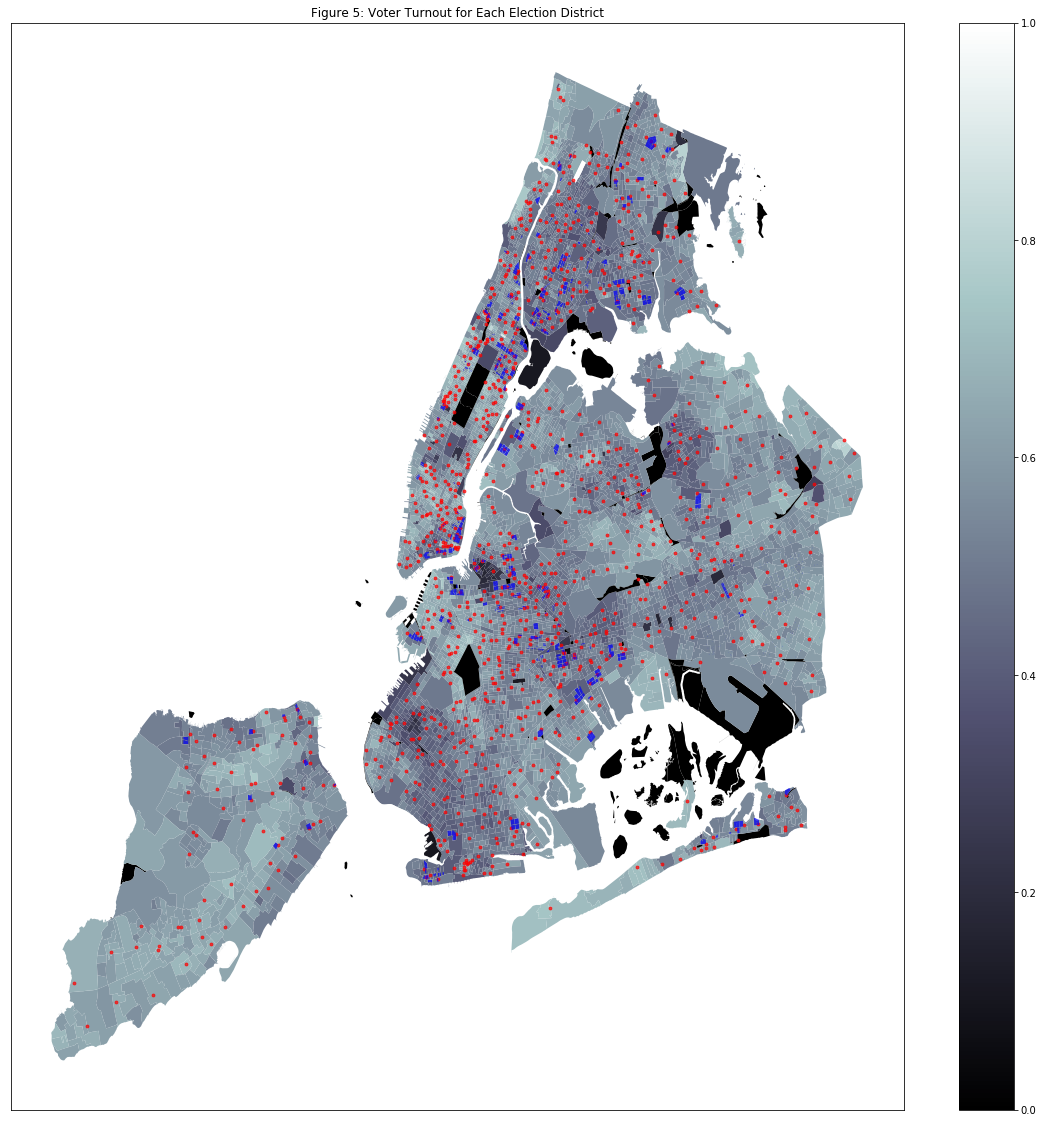

In [124]:
#Plot the shapefile chloropleth based on turnout. Plot over it poll sites and NYCHA lots
f, ax = plt.subplots(figsize=(20,20))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
base = all_votes.plot(column='ratio_voted',cmap='bone',alpha=1,
                  linewidth=0.1,ax=ax, legend=True)
poll_sites.plot(ax=base, marker="o",color='r', markersize=8, alpha=0.7)
nycha_map.plot(ax=base, color='b', markersize=8, alpha=0.7)
ax.set_title("Figure 5: Voter Turnout for Each Election District")

Figure 5 shows a color map of voter turnout across election districts. The red dots are the polling sites and the blue shapes are the NYCHA housing lots. The lighter the color, the greater the turnout, as seen in wealthy neighborhoods such as the Upper West Side, Upper East Side, and Todt Hill in Staten Island. With regards to low turnout, two low regions are South Willaimsburg and Borough Park, both of which have large Orthodox Jewish Populations.

## 2.2) Find the centroids and Nearest Poll lat/long of all Election Districts 

In [126]:
# Calculate the centroids of all election districts
all_votes['centroid'] = all_votes.geometry.centroid

In [127]:
# unary union of the poll site geomtries. Time Warning: Takes around 30 seconds
unary_union = poll_sites.unary_union

In [133]:
# Define near_lat. Warning: Takes about 10 minutes to run
def near_lat(point, pts=unary_union):
     '''find the nearest point and return the corresponding latitude'''
     nearest = poll_sites.geometry == nearest_points(point, pts)[1]
     return poll_sites[nearest].Latitude.get_values()[0]
all_votes['closest_poll_lat'] = all_votes.apply(lambda row: near_lat(row.geometry), axis=1)

In [134]:
# Define near_long. Warning: Takes about 10 minutes to run
def near_long(point, pts=unary_union):
     '''find the nearest point and return the corresponding longtiude'''
     nearest = poll_sites.geometry == nearest_points(point, pts)[1]
     return poll_sites[nearest].Longitude.get_values()[0]
all_votes['closest_poll_long'] = all_votes.apply(lambda row: near_long(row.geometry), axis=1)

In [135]:
#View the data
all_votes.head()

,elect_dist,shape_area,shape_leng,geometry,election_district,registered_voters,voted_in_2016,ratio_voted,centroid,closest_poll_lat,closest_poll_long
0,23002.0,5.646614e+06,13511.950233,POLYGON ((-73.91313180128004 40.56463824394601...,23002.0,1120.0,829.0,0.740179,POINT (-73.91755327110336 40.55952985576732),40.560781,-73.913894
1,23004.0,1.516480e+07,27487.651010,"POLYGON ((-73.86495467575234 40.5666314776016,...",23004.0,201.0,138.0,0.686567,POINT (-73.87608212917912 40.5671491274517),40.578205,-73.854401
2,23005.0,6.156202e+06,16269.643434,"POLYGON ((-73.85901463392794 40.5779871113073,...",23005.0,997.0,665.0,0.667001,POINT (-73.86166808901739 40.57115614267927),40.578205,-73.854401
3,23006.0,3.188046e+06,8261.763749,POLYGON ((-73.85324184655673 40.57138361205507...,23006.0,1013.0,731.0,0.721619,POINT (-73.85725294929438 40.5738718395746),40.578205,-73.854401
4,23007.0,3.454289e+06,10778.549525,POLYGON ((-73.84850444718799 40.57214844758093...,23007.0,981.0,708.0,0.721713,POINT (-73.85377013239174 40.57519230371563),40.578205,-73.854401


## 2.3) Calculate the Distance Between the Two

In [136]:
# Calculate the distance to the nearest poll site from each centroid. Warning: This takes 20 minutes. Make yourself a 
# cup of coffee.
R = 6373.0 #Radius of Earth in km
distance_list = []
for i in range(len(all_votes)):
    lat1 = radians(all_votes.centroid.y[i])
    lon1 = radians(all_votes.centroid.x[i])
    lat2 = radians(all_votes.closest_poll_lat[i])
    lon2 = radians(all_votes.closest_poll_long[i])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    distance_list.append(distance)

In [137]:
#Add the distsance list into the all_votes dataframe
all_votes['distance'] = pd.Series(distance_list)

## 2.4) Split the data into data tables of election districts with and without NYCHA housing 

In [138]:
#Split the election districts with NYCHA housing into a separate dataframe
sj = gpd.sjoin(all_votes, nycha, how='inner',op='intersects')
aff_votes = all_votes.geom_almost_equals(sj)
aff_votes = aff_votes[~aff_votes.index.duplicated()]
has_nycha = all_votes[aff_votes]

In [139]:
#View the data
has_nycha.head(5)

,elect_dist,shape_area,shape_leng,geometry,election_district,registered_voters,voted_in_2016,ratio_voted,centroid,closest_poll_lat,closest_poll_long,distance
index_left,,,,,,,,,,,,
32,23042.0,1.469588e+06,6479.197453,POLYGON ((-73.75248266251195 40.59924413326377...,23042.0,1191.0,658.0,0.552477,POINT (-73.75537781083541 40.59671904900731),40.594983,-73.753375,0.256712
56,23070.0,2.565272e+06,7832.480983,POLYGON ((-73.83952065325147 40.67996186921114...,23070.0,1145.0,584.0,0.510044,POINT (-73.83535930534713 40.6775202460088),40.678200,-73.839909,0.391167
68,23087.0,1.865373e+06,8502.706212,POLYGON ((-73.81319219668143 40.59112643829638...,23087.0,728.0,383.0,0.526099,POINT (-73.81393091185618 40.58888091014465),40.586266,-73.815719,0.327734
135,24060.0,1.112724e+06,5065.322181,POLYGON ((-73.81250544132247 40.70145799228798...,24060.0,391.0,153.0,0.391304,POINT (-73.81403429887767 40.70070318461853),40.704048,-73.811847,0.415253
170,25004.0,2.156794e+06,7033.190880,"POLYGON ((-73.7990131125804 40.72016477091042,...",25004.0,948.0,535.0,0.564346,POINT (-73.80370519052281 40.72049506236169),40.718222,-73.809450,0.546327


In [140]:
#Reset the index
has_nycha = has_nycha.reset_index(drop = True)
has_nycha.head()

,elect_dist,shape_area,shape_leng,geometry,election_district,registered_voters,voted_in_2016,ratio_voted,centroid,closest_poll_lat,closest_poll_long,distance
0,23042.0,1.469588e+06,6479.197453,POLYGON ((-73.75248266251195 40.59924413326377...,23042.0,1191.0,658.0,0.552477,POINT (-73.75537781083541 40.59671904900731),40.594983,-73.753375,0.256712
1,23070.0,2.565272e+06,7832.480983,POLYGON ((-73.83952065325147 40.67996186921114...,23070.0,1145.0,584.0,0.510044,POINT (-73.83535930534713 40.6775202460088),40.678200,-73.839909,0.391167
2,23087.0,1.865373e+06,8502.706212,POLYGON ((-73.81319219668143 40.59112643829638...,23087.0,728.0,383.0,0.526099,POINT (-73.81393091185618 40.58888091014465),40.586266,-73.815719,0.327734
3,24060.0,1.112724e+06,5065.322181,POLYGON ((-73.81250544132247 40.70145799228798...,24060.0,391.0,153.0,0.391304,POINT (-73.81403429887767 40.70070318461853),40.704048,-73.811847,0.415253
4,25004.0,2.156794e+06,7033.190880,"POLYGON ((-73.7990131125804 40.72016477091042,...",25004.0,948.0,535.0,0.564346,POINT (-73.80370519052281 40.72049506236169),40.718222,-73.809450,0.546327


Text(0.5,1,'Figure 6: Voter Turnout for Each Election District With NYCHA Housing')

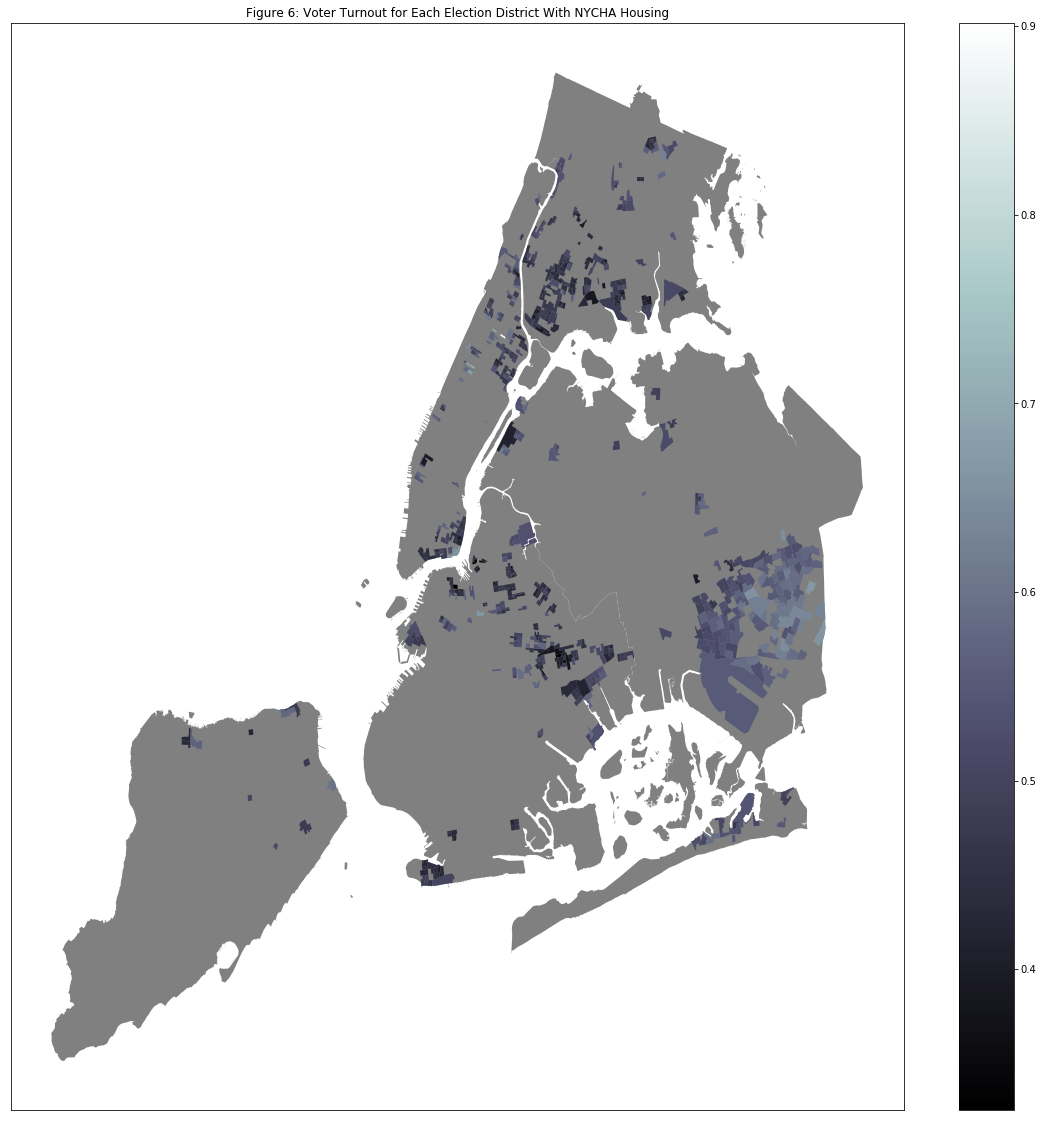

In [141]:
#Visualize the turnout chloropleth but for only ED with NYCHA housing
f, ax = plt.subplots(figsize=(20,20))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
background = outline.plot(color = 'grey',ax = ax)
base = has_nycha.plot(column='ratio_voted',cmap='bone',alpha=1,
                  linewidth=0.1,ax=ax, legend=True)
ax.set_title("Figure 6: Voter Turnout for Each Election District With NYCHA Housing")

Figure 6 shows only the colormap of turnout for only NYCHA containing districts. However, there appears to be an error among the shapes in the Jamaica area, where there doesn't appear to be NYCHA housing. This means that the code used to separate districts containing NYCHA housing needs to be optimized. Otherwise, the mapping looks fairly accurate. 

## 2.5) Get No Nycha Districts

In [142]:
#Make a list of districts with NYCHA housing
nycha_ed = list(has_nycha.elect_dist)

In [143]:
#Find districts that have no NYCHA housing
no_nycha = all_votes[~all_votes['elect_dist'].isin(nycha_ed)]

# 3) Statistical Testing

## 3.1) Comparison of Means and Distributions

### 3.1.1) Of Turnout

In [144]:
#Calculate the mean turnout for ED that both do and do not contain NYCHA housing
mean_no_nycha = no_nycha.ratio_voted.mean()
mean_ed_with_nycha = has_nycha.ratio_voted.mean()
print("Mean voter turnout of districts with no NYCHA housing is", mean_no_nycha)
print("Mean voter turnout of districts with NYCHA housing is",mean_ed_with_nycha)
print("Based on these two means, we can see that turnout among districts with NYCHA housing are lower.")

Mean voter turnout of districts with no NYCHA housing is 0.553266165196
Mean voter turnout of districts with NYCHA housing is 0.502178987391
Based on these two means, we can see that turnout among districts with NYCHA housing are lower.


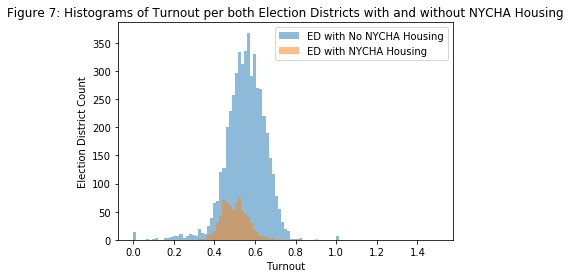

In [146]:
#Plot histograms of turnout for ED that both do and do not contain NYCHA housing
y = no_nycha.ratio_voted
x = has_nycha.ratio_voted

bins = np.linspace(0, 1.5, 100)


plt.hist(y, bins, alpha=0.5, label='ED with No NYCHA Housing')
plt.hist(x, bins, alpha=0.5, label='ED with NYCHA Housing')
plt.title('Figure 7: Histograms of Turnout per both Election Districts with and without NYCHA Housing')
plt.legend(loc='upper right')
plt.xlabel('Turnout')
plt.ylabel('Election District Count')
plt.show()

Figure 7 includes the two histograms of tunrout, with the blue being of election districts with no NYCHA housing and the the orange being with. Both these distributions appear almost normal. There is a small dip right at where the mean is within the orange distribution. 

In [147]:
#Perform KS test for distributions of ED that both do and do not contain NYCHA housing
stats.ks_2samp(no_nycha.ratio_voted, has_nycha.ratio_voted)

Ks_2sampResult(statistic=0.33858477767933731, pvalue=5.6432594870098447e-64)

### 3.1.2) Of Distance Between Pollsites and centroids

In [148]:
#Calculate the mean distance to poll sites for ED that both do and do not contain NYCHA housing
dist_no_nycha = no_nycha['distance'].mean()
dist_ed_with_nycha = has_nycha['distance'].mean()
print("Mean distance between centroid of districts with no NYCHA housing and nearest poll site is", dist_no_nycha)
print("Mean distance between centroid of districts with NYCHA housing and nearest poll site is",dist_ed_with_nycha)
print("Based on these two means, we can see that the average distance between ED with NYCHA housing and poll \
sites is smaller than without.")

Mean distance between centroid of districts with no NYCHA housing and nearest poll site is 0.343697664803
Mean distance between centroid of districts with NYCHA housing and nearest poll site is 0.267469837788
Based on these two means, we can see that the average distance between ED with NYCHA housing and poll sites is smaller than without.


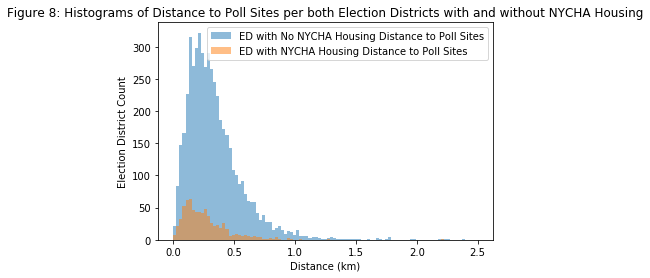

In [149]:
#Plot histograms of distance to poll sites for ED that both do and do not contain NYCHA housing
y = no_nycha['distance']
x = has_nycha['distance']

bins = np.linspace(0, 2.5, 100)


plt.hist(y, bins, alpha=0.5, label='ED with No NYCHA Housing Distance to Poll Sites')
plt.hist(x, bins, alpha=0.5, label='ED with NYCHA Housing Distance to Poll Sites')
plt.title('Figure 8: Histograms of Distance to Poll Sites per both Election Districts with and without NYCHA Housing')
plt.xlabel('Distance (km)')
plt.ylabel('Election District Count')
plt.legend(loc='upper right')
plt.show()

Figure 8 includes the two histograms of poll distance from centroids, with the blue being of election districts with no NYCHA housing and the the orange being with. Both these distributions appear poisson.

## 3.2 Is there a relationship between distances to poll sites and turnout amongst NYCHA Districts

In [151]:
#Convert the geodataframes to pandas dataframes
all_votes = pd.DataFrame(all_votes)
has_nycha = pd.DataFrame(has_nycha)

In [152]:
#Perform an OLS regression between distance to nearest poll sites and vote turnout for NYCHA containing districts
OLS=smf.ols(formula='ratio_voted~distance',data=has_nycha).fit()
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ratio_voted   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     21.10
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           5.15e-06
Time:                        22:30:24   Log-Likelihood:                 967.28
No. Observations:                 719   AIC:                            -1931.
Df Residuals:                     717   BIC:                            -1921.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.4878      0.004    124.543      0.000         0.480     0.495
distance       0.0538      0.012      4.593      0.000         0.031     0.077
==============================================================================
Omnibus:                       83.205   Durbin-Watson:                   1.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.411
Skew:                           0.638   Prob(JB):                     3.69e-43
Kurtosis:                       5.213   Cond. No.                         5.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,1,'Figure 9: Endogenous and Exogenous Variable Scatterplot')

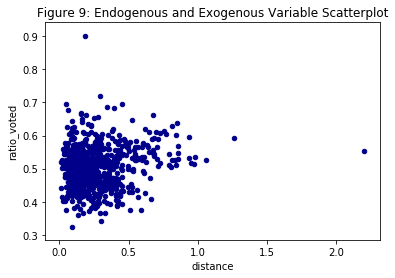

In [153]:
#Plot scatter plot
ax1 = has_nycha.plot.scatter(x='distance',y='ratio_voted',c='DarkBlue')
ax1.set_title('Figure 9: Endogenous and Exogenous Variable Scatterplot')

Figure 9 shows the scatter plot of endogenous and exogenous variables. They are Distance (km) and voter turnout respectively. There does not appear to be a relationship, as seen in the OLS model above. Next thing to do will be to observe the data in log space.

Text(0.5,1,'Figure 10: Endogenous and Exogenous Variable Scatterplot in Log Scales')

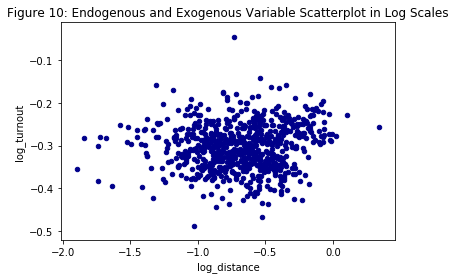

In [156]:
#Plot scatter plot in log space
has_nycha['log_distance'] = np.log10(has_nycha['distance'])
has_nycha['log_turnout'] = np.log10(has_nycha['ratio_voted'])
ax2 = has_nycha.plot.scatter(x='log_distance',y='log_turnout',c='DarkBlue')
ax2.set_title('Figure 10: Endogenous and Exogenous Variable Scatterplot in Log Scales')

Figure 10 shows the scatter plot of endogenous and exogenous variables in log space. They are Distance (km) and voter turnout respectively. There does not appear to be a relationship in this scaling either, suggesting there may not be any real discernable relationship.

# 4) Limitations of this study

1) Only looking at one feature. Should add features, such as race, income, education, etc. Distance to poll site, alone, should not be the only feature looked at.

2) NaN coordinates for poll sites affects the results of this model. Missing poll sites will increase the distances of the nearest poll sites.

In [155]:
#Count the number of NaNs
count_nan = len(poll_sites) - poll_sites.Location.count()
print("The number of poll sites dropped is",count_nan)

The number of poll sites dropped is 124


# 5) Conclusions

While this experiment may not prove what literature supports, this experiemnt found interesting results. First is that, on average, turnout is lower among districts with NYCHA housing than those without. While that doesn't mean that those within NYCHA housing don't vote, it could be due to instaces of unintended voter surpression, as seen when lead inspections, with required attendence of tennants, occured concurrently with the NYS primary election. There is still plenty of evidence that distance to poll sites affects turn out. However, we cannot prove their is a relationship between distance to poll sites and turnout based on the results of this experiment. 